In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import  classification_report, accuracy_score, f1_score, recall_score, precision_score
from xgboost import XGBClassifier

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

seed = 10

In [2]:
df = pd.read_csv('cleaned_algeriean_forest_fire.csv',parse_dates=['Date'])

In [3]:
df.head()

,Date,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,regions
0,2012-06-01,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
1,2012-06-02,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia
2,2012-06-03,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
3,2012-06-04,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,Bejaia
4,2012-06-05,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,Bejaia


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         244 non-null    datetime64[ns]
 1   Temperature  244 non-null    int64         
 2   RH           244 non-null    int64         
 3   Ws           244 non-null    int64         
 4   Rain         244 non-null    float64       
 5   FFMC         244 non-null    float64       
 6   DMC          244 non-null    float64       
 7   DC           244 non-null    float64       
 8   ISI          244 non-null    float64       
 9   BUI          244 non-null    float64       
 10  FWI          244 non-null    float64       
 11  Classes      244 non-null    object        
 12  regions      244 non-null    object        
dtypes: datetime64[ns](1), float64(7), int64(3), object(2)
memory usage: 24.9+ KB


In [5]:
le = LabelEncoder()
df['Classes'] = le.fit_transform(df['Classes'])

In [6]:
X = df.iloc[:,1:11]
y = df.iloc[:,11]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y,random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.25,shuffle=True,stratify=y_train,random_state=seed)

In [8]:
print('X_train shpae : ',X_train.shape,'\nX_test shpae : ',X_test.shape,'\nX_val shpae : ',X_val.shape)

X_train shpae :  (146, 10) 
X_test shpae :  (49, 10) 
X_val shpae :  (49, 10)


### Decision Tree Classification

In [10]:
param_dist = {
    'max_depth':np.arange(1,50),
    'min_samples_split': np.arange(2,50),
    'min_samples_leaf':np.arange(1,50),
    'max_features':['sqrt','log2',None],
    'criterion':['gini','entropy','log_loss']
             }

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(
        random_state=seed
    ),
    param_dist,
    n_iter=25,
    verbose=4,
    n_jobs=-1,
    return_train_score=True,
    random_state=seed
)

In [11]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=10), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'max_features': ['sqrt', 'log2', None],
                                        'mi...4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
                   random_state=10, return_train_score=True, verbose=4)

In [12]:
random_search.best_params_

{'min_samples_split': 43,
 'min_samples_leaf': 41,
 'max_features': None,
 'max_depth': 49,
 'criterion': 'gini'}

In [13]:
print('Train Score:                 ','%.2f'%random_search.score(X_train,y_train),'%')
print('Best Cross Validation Score: ','%.2f'%random_search.best_score_,'%')
print('Test Score:                 ','%.2f'%random_search.score(X_test,y_test),'%')

Train Score:                  0.99 %
Best Cross Validation Score:  0.97 %
Test Score:                  0.98 %


In [14]:
# A function to visualize Hyperparameter space

def plot_hpperform(
                searchcv,
                row=None,
                col=2,
                figsize=(15,15),
                line_kws={'errorbar':None},
                point_kws={},
                best_color=None,
                scatter_kws={'alpha':.4},
                strip_kws={'alpha':.4},
                fontsize=12,
                plot_train_score=False,
                train_color=None,
                points=True,
                best=True
                ):


    '''
    Plot hyperparameter peroformance in hyperparameter space
    '''
    # import seaborn
    try:
        import seaborn as sns
    except ImportError:
        import subprocess
        import sys
        print("Installing seaborn...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
        import seaborn as sns

    # initializing necessary variables
    cv_results_ = searchcv.cv_results_
    keys = cv_results_.keys()
    param_ = [i for i in keys if 'param_' in i]
    row = len(param_) // col + 1 if not row else row
    n_splits_ = searchcv.n_splits_
    
    fig, axes = plt.subplots(row,col,figsize=figsize)
    axes = axes.flatten()

    # delete unncessary axes
    unused = (row*col) - len(param_)
    for i in range(unused):
        axes[-(i+1)].remove()

    # setting up x and y for plotting
    all_cv_score = []
    if plot_train_score:
        all_train_score = [] 
        train_color = sns.color_palette()[1] if not train_color else train_color
    for j in range(n_splits_):
        all_cv_score.extend(cv_results_[f'split{j}_test_score'])
        if plot_train_score:
            all_train_score.extend(cv_results_[f'split{j}_train_score'])

    # looping over to plot all the hyperparameters vs score        
    for i in range(len(param_)):
        ax = axes[i]   
        
        kws = dict(
            y= all_cv_score,
            x= np.tile(cv_results_[param_[i]],5),
            ax=ax,
        )

        # avoiding error for None
        kws['x'] = ['None' if i is None else i for i in kws['x'] ]
        
        
        if plot_train_score:
            train_kws = dict(
                y= all_train_score,
                x= np.tile(cv_results_[param_[i]],5),
                ax=ax,
                color=train_color
            )
            train_kws['x'] = ['None' if i is None else i for i in train_kws['x']]

        # plotting pointplot and stripplot for categorical values
        if isinstance(kws['x'][0],str):
            sns.pointplot(**kws,**point_kws,label='CV Scores')
            if points:
                sns.stripplot(**kws,**strip_kws,label='CV Scores')
            
            # plotting train scores
            if plot_train_score:
                sns.pointplot(**train_kws,**point_kws,label='train_score')
                if points:
                  sns.stripplot(**train_kws,**strip_kws,label='train_score')

            # plotting the best parameter
            if best:
                best_score_ = searchcv.best_score_
                best_x = [searchcv.best_params_[param_[i].replace('param_','')]]
                best_x = ['None' if best_x[0] is None else best_x[0]]
                best_color = sns.color_palette()[3] if not best_color else best_color
                sns.pointplot(y=best_score_,x=best_x,color=best_color,ax=ax,label='best Hyperparameter')
        
        # plotting lineplot and scatterplot for nuumerical values
        else:
            sns.lineplot(**kws,**line_kws,label='CV Scores')
            if points:
                sns.scatterplot(**kws,**scatter_kws,label='CV Scores')

            # plotting train scores
            if plot_train_score:
                sns.lineplot(**train_kws,**line_kws,label='train_score')
                if points:
                    sns.scatterplot(**train_kws,**scatter_kws,label='train_score')
            
            # plotting the best parameter
            if best:
                best_score_ = searchcv.best_score_
                best_x = [searchcv.best_params_[param_[i].replace('param_','')]]
                best_color = sns.color_palette()[3] if not best_color else best_color
                sns.scatterplot(y=best_score_,x=best_x,color=best_color,ax=ax,label='best Hyperparameter')
        
        ax.set_xlabel(param_[i].replace('param_',''),fontsize=fontsize)
        ax.set_ylabel('score',fontsize=fontsize)
        ax.legend()
   
    plt.suptitle('Hyperparameter Performance',y=0.95,fontsize=fontsize*2)
    return fig,axes.reshape(row,col)

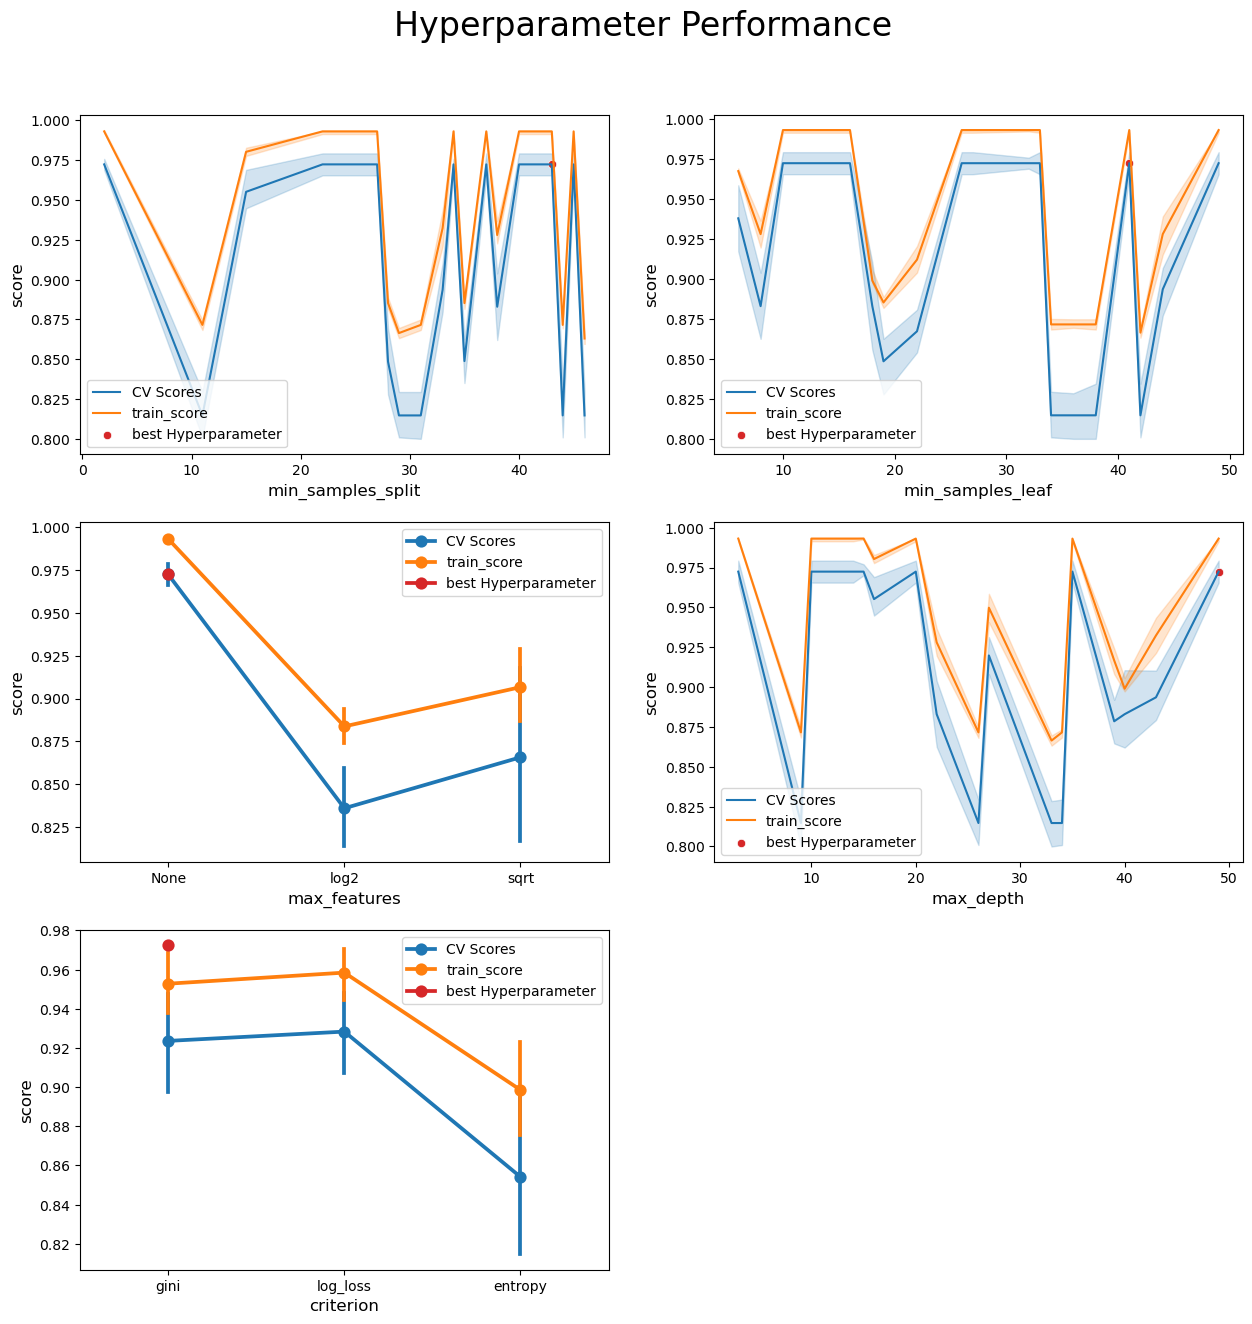

In [15]:
plot_hpperform(random_search,line_kws=dict(errorbar=('ci',40)),plot_train_score=True,points=False,best=True)
plt.show()

In [16]:
print(classification_report(le.inverse_transform(y_test),le.inverse_transform(random_search.predict(X_test))))

              precision    recall  f1-score   support

        fire       0.97      1.00      0.98        28
    not fire       1.00      0.95      0.98        21

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49



This model can account for all the fires and is 98% of the time it's warinigs are accurate

In [18]:
dt =  DecisionTreeClassifier(
        min_samples_split= 38,
        min_samples_leaf= 4,
        max_features= 'log2',
        max_depth= 32,
        criterion= 'log_loss',
        random_state=seed
    )

In [19]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(criterion='log_loss', max_depth=32, max_features='log2',
                       min_samples_leaf=4, min_samples_split=38,
                       random_state=10)

In [20]:
print('Train accuracy Score:                 ','%.2f'%dt.score(X_train,y_train),'%')
print('Test accuracy Score:                 ','%.2f'%dt.score(X_test,y_test),'%')

Train accuracy Score:                  0.97 %
Test accuracy Score:                  0.92 %


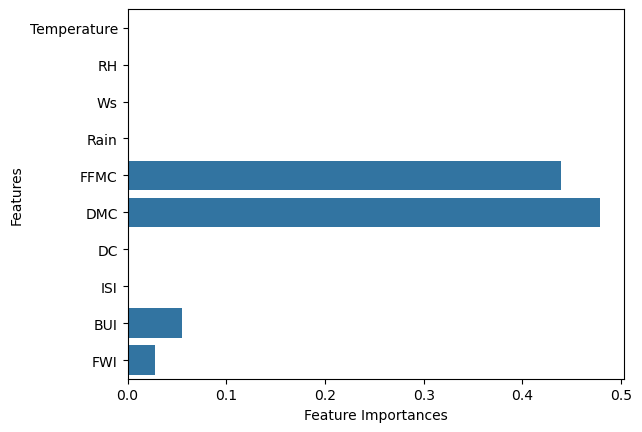

In [21]:
feat_imp = dt.feature_importances_
feat = dt.feature_names_in_
bar = sns.barplot(y=feat,x=feat_imp)
bar.set_ylabel('Features')
bar.set_xlabel('Feature Importances')
plt.show()

### Random Forest Classification

In [23]:
param_dist = {
    'n_estimators': np.arange(10,130,10),
    'max_depth':np.arange(1,50),
    'min_samples_split': np.arange(2,50),
    'min_samples_leaf':np.arange(1,50),
    'max_features':['sqrt','log2',None],
    'criterion':['gini','entropy','log_loss']
             }

random_search = RandomizedSearchCV(
    RandomForestClassifier(
        random_state=seed
    ),
    param_dist,
    n_iter=25,
    verbose=4,
    n_jobs=-1,
    return_train_score=True,
    random_state=seed
)

In [24]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(estimator=RandomForestClassifier(random_state=10), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'max_features': ['sqrt', 'log2', None],
                                        'mi...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120])},
                   random_state=10, return_train_score=True, verbose=4)

In [25]:
random_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 30,
 'min_samples_leaf': 12,
 'max_features': 'log2',
 'max_depth': 25,
 'criterion': 'log_loss'}

In [26]:
print('Train Score:                 ','%.2f'%random_search.score(X_train,y_train),'%')
print('Best Cross Validation Score: ','%.2f'%random_search.best_score_,'%')
print('Test Score:                 ','%.2f'%random_search.score(X_test,y_test),'%')

Train Score:                  0.99 %
Best Cross Validation Score:  0.99 %
Test Score:                  0.98 %


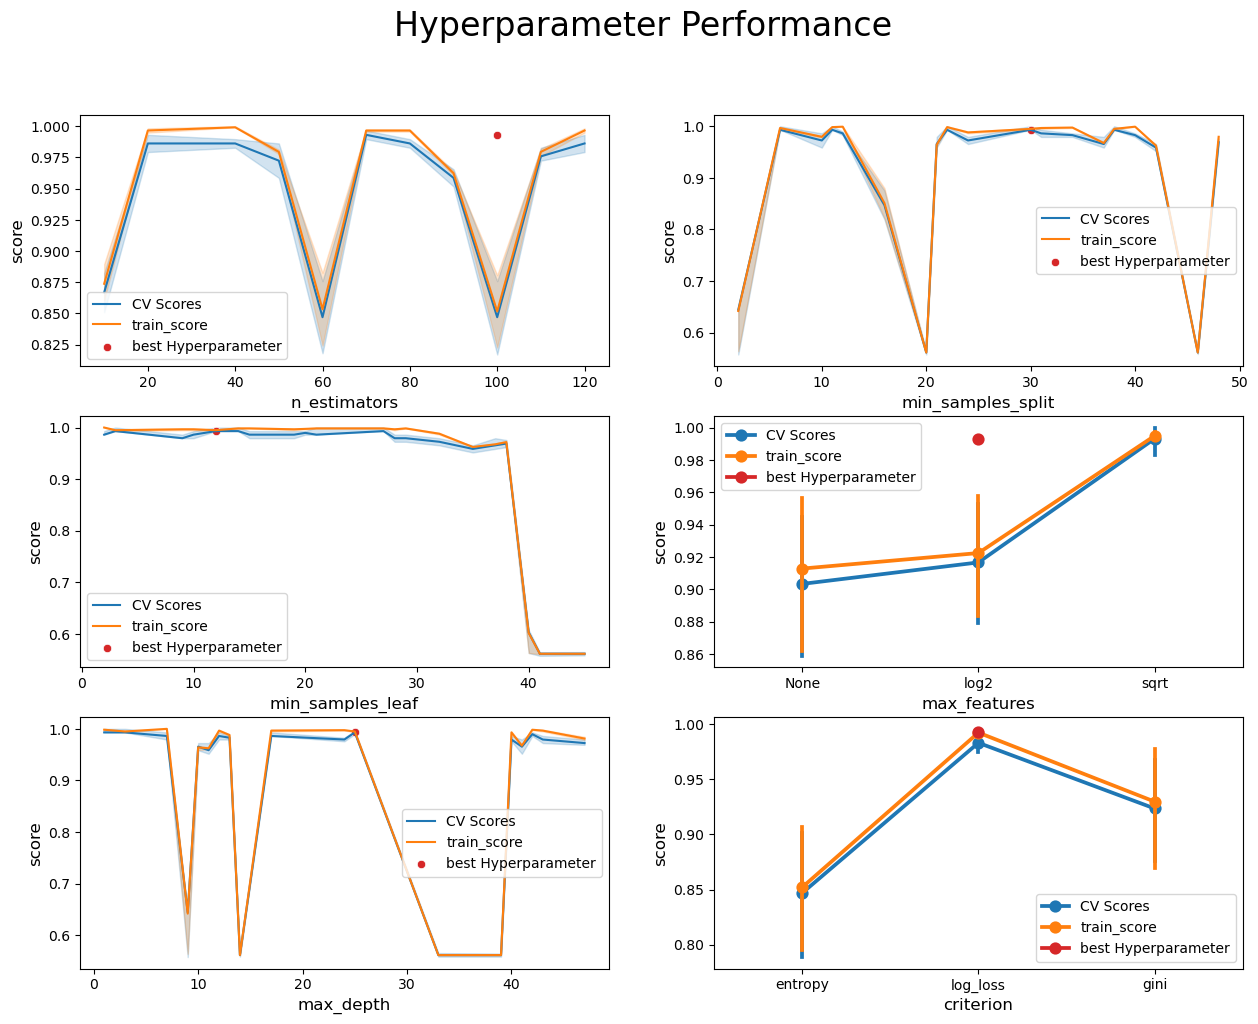

In [27]:
plot_hpperform(random_search,line_kws=dict(errorbar=('ci',40)),plot_train_score=True,points=False,best=True)
plt.show()

In [28]:
print(classification_report(le.inverse_transform(y_test),le.inverse_transform(random_search.predict(X_test))))

              precision    recall  f1-score   support

        fire       0.97      1.00      0.98        28
    not fire       1.00      0.95      0.98        21

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49



In [29]:
rf =  RandomForestClassifier(
        n_estimators=50,
        min_samples_split= 10,
        min_samples_leaf= 38,
        max_features= 'sqrt',
        max_depth= 32,
        criterion= 'log_loss',
        random_state=seed
    )

In [30]:
rf.fit(X_train,y_train)

RandomForestClassifier(criterion='log_loss', max_depth=32, min_samples_leaf=38,
                       min_samples_split=10, n_estimators=50, random_state=10)

In [31]:
print('Train accuracy Score:                 ','%.2f'%rf.score(X_train,y_train),'%')
print('Test accuracy Score:                 ','%.2f'%rf.score(X_test,y_test),'%')

Train accuracy Score:                  0.99 %
Test accuracy Score:                  0.98 %


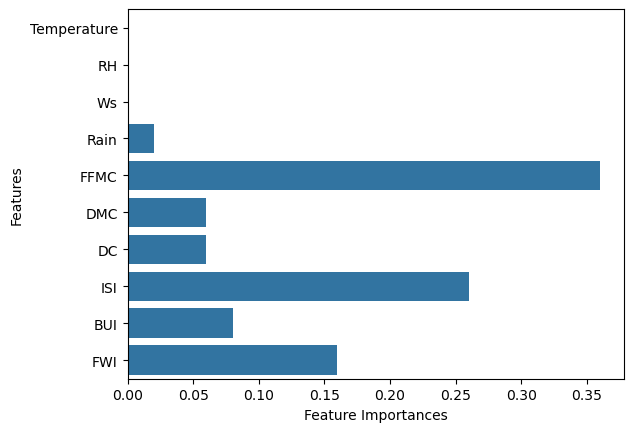

In [32]:
feat_imp = rf.feature_importances_
feat = rf.feature_names_in_
bar = sns.barplot(y=feat,x=feat_imp)
bar.set_ylabel('Features')
bar.set_xlabel('Feature Importances')
plt.show()

### XGBoost Classification

In [34]:
param_dist = {
    'n_estimators':np.arange(10,70,10),
    'learning_rate':np.arange(0.05,0.2,0.01),
    'max_depth':np.arange(1,13),
    'max_leaves':np.arange(1,50),
    'colsample_bytree':np.arange(0.5,1,0.1),
    'min_child_weight':np.arange(1,11),
    'gamma':np.arange(0.5,1,0.1),
    'reg_lambda':np.arange(15,26)
             }

random_search = RandomizedSearchCV(
    XGBClassifier(
        random_state=seed,
        reg_alpha=5
    ),
    param_dist,
    n_iter=250,
    verbose=4,
    n_jobs=-1,
    return_train_score=True,
    refit='r2',
    random_state=seed
)

In [35]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=No...
                                        'max_leaves': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_child_weight': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60]),
                                        'reg_lambda': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])},
                   random_state=10, refit='r2', return_train_score=True,
                   verbose=4)

In [36]:
random_search.best_params_

{'reg_lambda': 18,
 'n_estimators': 20,
 'min_child_weight': 3,
 'max_leaves': 25,
 'max_depth': 3,
 'learning_rate': 0.2,
 'gamma': 0.5,
 'colsample_bytree': 0.5}

In [37]:
print('Train Score:                 ','%.2f'%random_search.score(X_train,y_train),'%')
print('Best Cross Validation Score: ','%.2f'%random_search.best_score_,'%')
print('Test Score:                 ','%.2f'%random_search.score(X_test,y_test),'%')

Train Score:                  1.00 %
Best Cross Validation Score:  0.99 %
Test Score:                  0.98 %


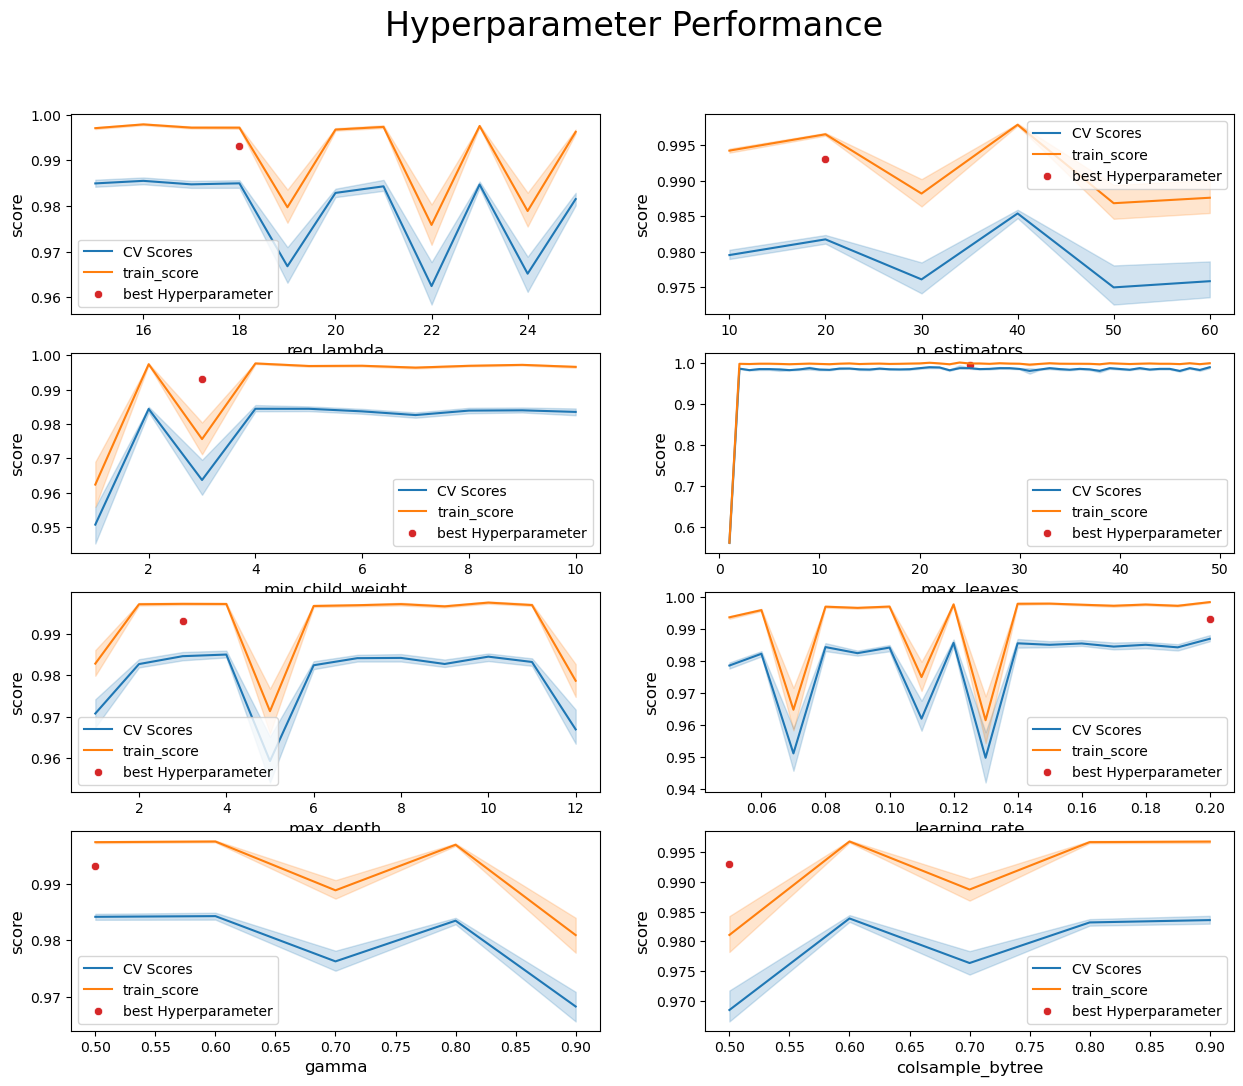

In [38]:
plot_hpperform(random_search,line_kws=dict(errorbar=('ci',40)),plot_train_score=True,points=False,best=True)
plt.show()

In [39]:
print(classification_report(le.inverse_transform(y_test),le.inverse_transform(random_search.predict(X_test))))

              precision    recall  f1-score   support

        fire       0.97      1.00      0.98        28
    not fire       1.00      0.95      0.98        21

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49



In [40]:
xgbc = XGBClassifier(
        reg_lambda= 18,
        n_estimators= 20,
        min_child_weight= 3,
        max_leaves= 25,
        max_depth= 3,
        learning_rate= 0.2,
        gamma= 0.5,
        colsample_bytree= 0.6,
        random_state=seed,
        reg_alpha=5
)

In [41]:
xgbc.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=25, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=20,
              n_jobs=None, num_parallel_tree=None, ...)

In [42]:
print('Train accuracy Score:                 ','%.2f'%xgbc.score(X_train,y_train),'%')
print('Test accuracy Score:                 ','%.2f'%xgbc.score(X_test,y_test),'%')

Train accuracy Score:                  0.99 %
Test accuracy Score:                  0.98 %


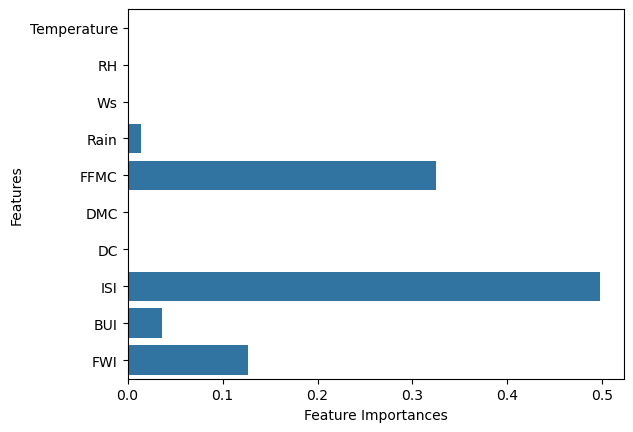

In [43]:
feat_imp = xgbc.feature_importances_
feat = xgbc.feature_names_in_
bar = sns.barplot(y=feat,x=feat_imp)
bar.set_ylabel('Features')
bar.set_xlabel('Feature Importances')
plt.show()

In [44]:
def score_compare(models,scores,X,y):

    import pandas as pd
    
    if not isinstance(models,dict):
        raise Exception('Prove the model and model name in a dictionary format')
    if not isinstance(scores,list):
        scores = [scores]


    model_names = list(models.keys())
    score_names = [score.__name__ for score in scores]

    output = pd.DataFrame(index=model_names,columns=score_names)
    for m in range(len(models)):
        for s in range(len(scores)):
            output.loc[model_names[m],score_names[s]] = scores[s](y,models[model_names[m]].predict(X))
    return output

In [45]:
models = {'Decision Tree':dt,
          'Random Forest':rf,
          'XG Boost':xgbc}

In [46]:
score_compare(models,[accuracy_score, f1_score, recall_score, precision_score],X_test,y_test)

,accuracy_score,f1_score,recall_score,precision_score
Decision Tree,0.918367,0.904762,0.904762,0.904762
Random Forest,0.979592,0.97561,0.952381,1.0
XG Boost,0.979592,0.97561,0.952381,1.0


### Model Significance Test

In [48]:
cv_scores = {}
for name,model in models.items():
    scores = cross_val_score(model, X_val, y_val, cv=5, scoring="accuracy")
    cv_scores[name] = scores

f_stat, pval = f_oneway(cv_scores['Decision Tree'],cv_scores['Random Forest'],cv_scores['XG Boost'])
print('ANOVA f-statistics ',f_stat,' p-value ',pval)

ANOVA f-statistics  17.039247751430906  p-value  0.00031195915308187985


p-value is less than 0.05 so there is significant difference exists.

In [50]:
scores = np.concatenate([cv_scores['Decision Tree'],cv_scores['Random Forest'],cv_scores['XG Boost']])
models = ['Decision Tree']*5 + ['Random Forest']*5 +['XG Boost']*5
tukey = pairwise_tukeyhsd(scores, models, alpha=0.05)
print(tukey.summary())

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
Decision Tree Random Forest  -0.2289 0.0093 -0.3982 -0.0596   True
Decision Tree      XG Boost   0.1378  0.117 -0.0315  0.3071  False
Random Forest      XG Boost   0.3667 0.0002  0.1974   0.536   True
------------------------------------------------------------------


We can come to this conclusion that Random Forest perofrms significantly better than Decision Tree and XGBoost.